/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observa

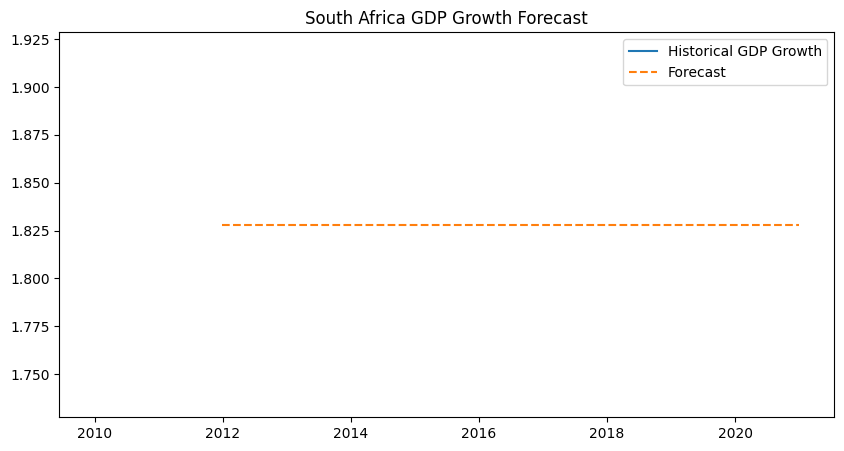

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = "/content/South_Africa_Sustainability_Dataset.csv"
df = pd.read_csv(file_path)

# Clean dataset
df = df.dropna()
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# --- TIME SERIES FORECAST: GDP Growth ---
gdp = df['GDP per capita growth (%)']

# Fit ARIMA model
model = ARIMA(gdp, order=(2,1,2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)

# Plot forecast
plt.figure(figsize=(10,5))
plt.plot(gdp, label='Historical GDP Growth')
plt.plot(pd.date_range(gdp.index[-1], periods=11, freq='Y')[1:], forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("South Africa GDP Growth Forecast")
plt.show()

# --- MACHINE LEARNING: Predict GDP from Human Capital & Renewables ---
features = df[['Human capital index (HCI), overall',
               'Renewable energy consumption (% of total final energy)',
               'Employment to population ratio (%)',
               'Population growth (annual %)',
               'Forest area (% of land area)']]

target = df['GDP per capita growth (%)']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Random Forest MSE:", mse)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features.columns)
importances.sort_values().plot(kind='barh', title="Feature Importance for GDP Growth")
plt.show()


=== Columns overview (non-null counts) ===
                                                    non_null_before  \
Air transport, passengers carried                                52   
Employment to population ratio (%)                               34   
Forest area (% of land area)                                     33   
GDP per capita growth (%)                                        64   
Gini index                                                        6   
Human capital index (HCI), overall                                4   
Logistics performance index (1=low to 5=high)                     7   
Population growth (annual %)                                     64   
Renewable energy consumption (% of total final ...               32   

                                                    non_null_after  
Air transport, passengers carried                               64  
Employment to population ratio (%)                              64  
Forest area (% of land area)           

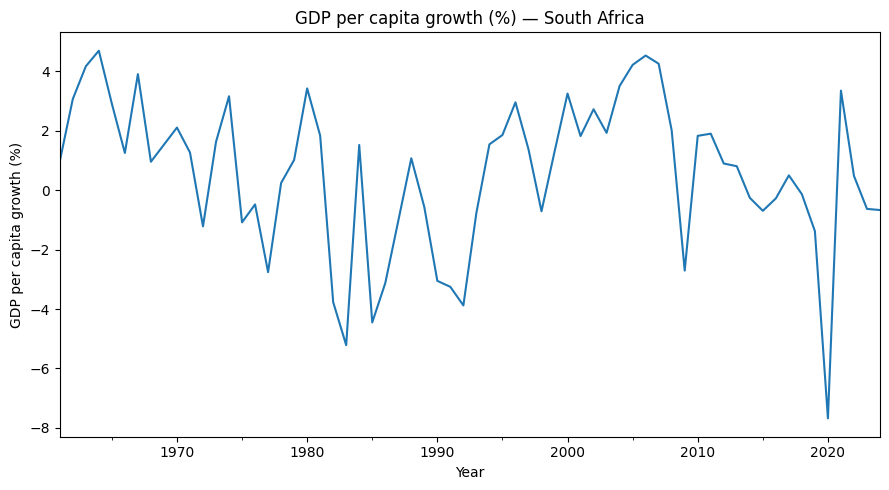

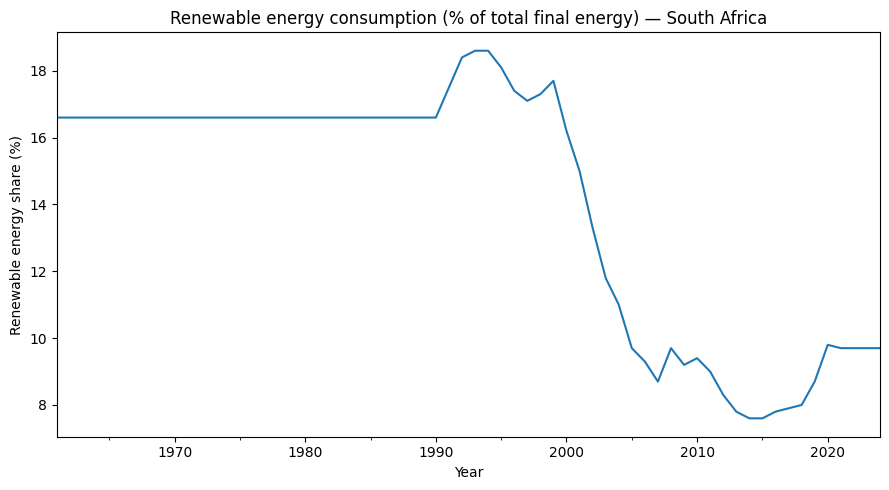

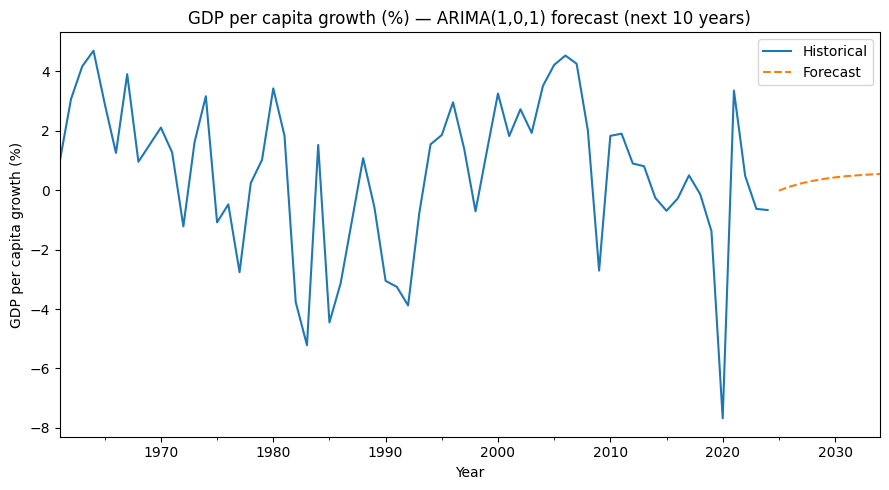

Saved forecast CSV: /mnt/data/gdp_growth_forecast.csv
Random Forest — MSE: 2.864645556862593  R^2: 0.22793875470802705

Top feature importances:
Population growth (annual %)                              0.418345
Air transport, passengers carried                         0.276697
Employment to population ratio (%)                        0.107334
Renewable energy consumption (% of total final energy)    0.056238
Gini index                                                0.055802
Forest area (% of land area)                              0.042238
Logistics performance index (1=low to 5=high)             0.026044
Human capital index (HCI), overall                        0.017302
dtype: float64


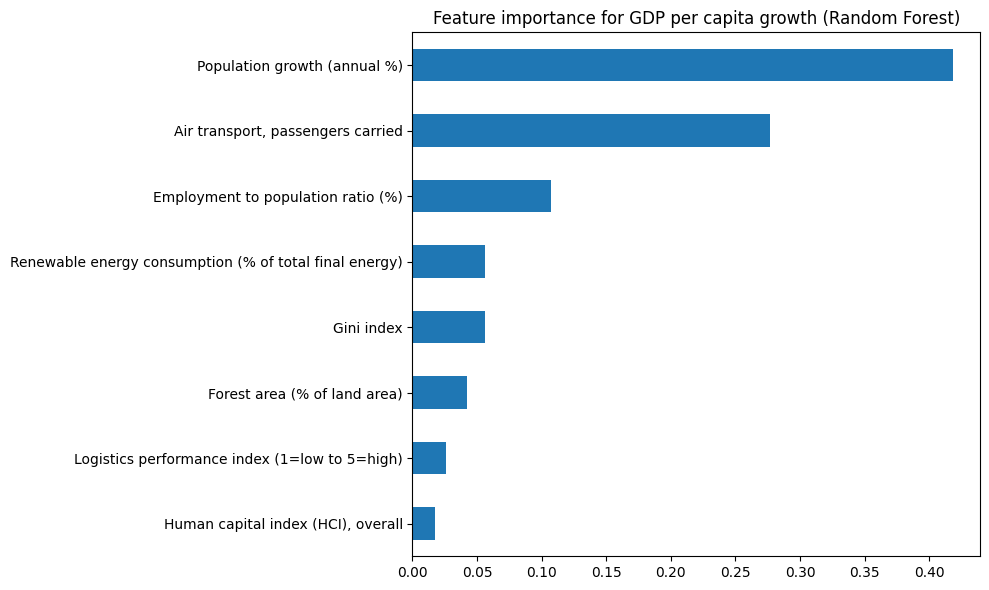

Saved report: /mnt/data/analysis_report.txt


In [2]:
# ===== South Africa Sustainability: Time Series + ML Analysis =====
# Requirements: pandas, numpy, matplotlib, statsmodels, scikit-learn
# File expected: /mnt/data/South_Africa_Sustainability_Dataset.csv

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Time-series model
from statsmodels.tsa.arima.model import ARIMA

# ML model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1) Load & basic cleaning
# --------------------------
DATA_PATH = "/content/South_Africa_Sustainability_Dataset.csv"
OUT_DIR = Path("/mnt/data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_raw = pd.read_csv(DATA_PATH)

# Coerce numerics (keep 'Year' as separate)
df = df_raw.copy()
for c in df.columns:
    if c != "Year":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Make Year a datetime index (annual)
df["Year"] = pd.to_datetime(df["Year"], format="%Y", errors="coerce")
df = df.dropna(subset=["Year"]).sort_values("Year").set_index("Year")

# Keep columns that have at least a few non-null points
usable_cols = [c for c in df.columns if df[c].notna().sum() >= 3]
df = df[usable_cols].copy()

# Interpolate over time, then fill edges
df_interp = df.interpolate(method="time", limit_direction="both")
df_interp = df_interp.fillna(method="ffill").fillna(method="bfill")

# Quick overview table
overview = pd.DataFrame({
    "non_null_before": df.notna().sum(),
    "non_null_after": df_interp.notna().sum(),
})
print("=== Columns overview (non-null counts) ===")
print(overview)

# --------------------------
# 2) EDA plots (matplotlib)
# --------------------------
def maybe_plot(series_name, title, ylabel):
    if series_name in df_interp.columns:
        plt.figure(figsize=(9,5))
        df_interp[series_name].plot()
        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

maybe_plot("GDP per capita growth (%)",
           "GDP per capita growth (%) — South Africa",
           "GDP per capita growth (%)")

maybe_plot("Renewable energy consumption (% of total final energy)",
           "Renewable energy consumption (% of total final energy) — South Africa",
           "Renewable energy share (%)")

# --------------------------
# 3) ARIMA forecast (10 yrs)
# --------------------------
target_col = "GDP per capita growth (%)"
arima_summary_text = None
forecast_df = None

if target_col in df_interp.columns and df_interp[target_col].notna().sum() >= 15:
    y = df_interp[target_col].dropna()

    # GDP growth is often stationary → start with ARIMA(1,0,1)
    model = ARIMA(y, order=(1,0,1))
    fit = model.fit()

    steps = 10  # forecast next 10 years
    fcast_vals = fit.forecast(steps=steps)

    last_year = y.index.max().year
    f_index = pd.to_datetime([f"{yy}-01-01" for yy in range(last_year+1, last_year+1+steps)])
    forecast_df = pd.DataFrame({"forecast_gdp_growth": fcast_vals.values}, index=f_index)

    # Plot
    plt.figure(figsize=(9,5))
    y.plot(label="Historical")
    forecast_df["forecast_gdp_growth"].plot(style="--", label="Forecast")
    plt.title("GDP per capita growth (%) — ARIMA(1,0,1) forecast (next 10 years)")
    plt.xlabel("Year")
    plt.ylabel("GDP per capita growth (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    arima_summary_text = fit.summary().as_text()

    # Save forecast CSV
    forecast_csv = OUT_DIR / "gdp_growth_forecast.csv"
    forecast_df.to_csv(forecast_csv, index_label="Year")
    print("Saved forecast CSV:", forecast_csv)

else:
    print("Not enough valid GDP growth data for ARIMA (need ≥15 non-null years).")

# --------------------------
# 4) ML: Predict GDP growth
# --------------------------
ml_metrics = {}
feature_cols = [c for c in df_interp.columns if c != target_col]

if target_col in df_interp.columns and len(df_interp) >= 20 and len(feature_cols) >= 2:
    X = df_interp[feature_cols].copy()
    y = df_interp[target_col].copy()

    # Replace infinities and fill any remaining gaps
    X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")
    y = y.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")

    # If very short sample, reduce test size
    test_size = 0.2 if len(X) >= 25 else 0.15
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=True, random_state=42
    )

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ml_metrics = {"mse": float(mse), "r2": float(r2)}
    print("Random Forest — MSE:", mse, " R^2:", r2)

    # Feature importances
    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop feature importances:")
    print(importances.head(10))

    # Plot importances
    plt.figure(figsize=(10,6))
    importances.sort_values().plot(kind="barh",
                                   title="Feature importance for GDP per capita growth (Random Forest)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to train ML model (need ≥20 rows and ≥2 predictors).")

# --------------------------
# 5) Save a plain-text report
# --------------------------
report_lines = []
report_lines.append("=== DATA CLEANING OVERVIEW ===\n")
report_lines.append(overview.to_string())
report_lines.append("\n\n=== ML METRICS (Random Forest predicting GDP growth) ===\n")
report_lines.append(str(ml_metrics))

if arima_summary_text:
    report_lines.append("\n\n=== ARIMA(1,0,1) MODEL SUMMARY ===\n")
    report_lines.append(arima_summary_text)

report_path = OUT_DIR / "analysis_report.txt"
report_path.write_text("\n".join(report_lines))
print("Saved report:", report_path)
